In [1]:
# Basic NGSolve things
from netgen.csg import *
from ngsolve import *
from ngsolve.webgui import Draw

import matplotlib.pyplot as plt
import numpy as np
import matplotlib 
matplotlib.rcParams.update({'font.size': 18})

# %matplotlib inline
import compare_my_method
plt.rc('text', usetex=False) # don't use Latex as Binder currently fails, see https://github.com/jupyterhub/binderhub/issues/1143

# Mesh

In [2]:
# painful: build geometry/mesh
def GenMesh(h0=0.5, h1 = 0.5, h2 = 0.5):
    geo = CSGeometry()
    for i in range(2):
        for j in range(2):
            for k in range(2):
                x0 = i*0.5
                x1 = (i+1)*0.5
                y0 = j*0.5
                y1 = (j+1)*0.5
                z0 = k*0.5
                z1 = (k+1)*0.5
                if i==1 and j==1 and k==1: # upper corner
                    for i1 in range(2):
                        for j1 in range(2):
                            for k1 in range(2):
                                x0 = 0.5+i1*0.25
                                x1 = 0.5+(i1+1)*0.25
                                y0 = 0.5+j1*0.25
                                y1 = 0.5+(j1+1)*0.25
                                z0 = 0.5+k1*0.25
                                z1 = 0.5+(k1+1)*0.25
                                if i1==1 and j1==1 and k1==1:
                                    for i2 in range(2):
                                        x0 = 0.75+i2*0.125
                                        x1 = 0.75+(i2+1)*0.125
                                        for j2 in range(2):
                                            y0 = 0.75+j2*0.125
                                            y1 = 0.75+(j2+1)*0.125
                                            for k2 in range(2):
                                                z0 = 0.75+k2*0.125
                                                z1 = 0.75+(k2+1)*0.125
                                                geo.Add(OrthoBrick(Pnt(x0,y0,z0), Pnt(x1,y1,z1)).maxh(h2))
                                elif i1==0 and j1==0 and k1==0:
                                    for i2 in range(2):
                                        x0 = 0.5+i2*0.125
                                        x1 = 0.5+(i2+1)*0.125
                                        for j2 in range(2):
                                            y0 = 0.5+j2*0.125
                                            y1 = 0.5+(j2+1)*0.125
                                            for k2 in range(2):
                                                z0 = 0.5+k2*0.125
                                                z1 = 0.5+(k2+1)*0.125
                                                geo.Add(OrthoBrick(Pnt(x0,y0,z0), Pnt(x1,y1,z1)).maxh(h2))
                                else:
                                    geo.Add(OrthoBrick(Pnt(x0,y0,z0), Pnt(x1,y1,z1)).maxh(h1))
                elif i==0 and j==0 and k==0: # use four cubes
                    for i1 in range(2):
                        x0 = i1*0.25
                        x1 = (i1+1)*0.25
                        for j1 in range(2):
                            y0 = j1*0.25
                            y1 = (j1+1)*0.25
                            for k1 in range(2):
                                z0 = k1*0.25
                                z1 = (k1+1)*0.25
                                geo.Add(OrthoBrick(Pnt(x0,y0,z0), Pnt(x1,y1,z1)).maxh(h1))
                else:
                    geo.Add(OrthoBrick(Pnt(x0,y0,z0), Pnt(x1,y1,z1)))
    # add two more cubes for 
    mesh = Mesh(geo.GenerateMesh(maxh=h0))

    # domain flags:
    K30 = 1
    K31 = 0.1

    for i in range(len(mesh.GetMaterials())):
        mesh.ngmesh.SetMaterial(i+1, "O0")
    mesh.ngmesh.SetMaterial(12,"O1")
    mesh.ngmesh.SetMaterial(13,"O1")
    mesh.ngmesh.SetMaterial(19,"O1")
    mesh.ngmesh.SetMaterial(20,"O1")
    mesh.ngmesh.SetMaterial(26,"O1")
    mesh.ngmesh.SetMaterial(27,"O1")

    vol_values = {'O1': K31, 'O0': K30}
    values_list = [vol_values[bc]
                   if bc in vol_values.keys() else 0
                   for bc in mesh.GetMaterials()]
    K0 = CoefficientFunction(values_list)
#     gfu = GridFunction(H1(mesh))
#     gfu.Set(K0)
#     Draw(K0, mesh, 'piecewise')


    # boundary flags
    eps = 1e-3
    cIn = 0
    cOut = 0
    for e in mesh.Elements(BND):
        p0 = mesh[e.vertices[0]].point
        p1 = mesh[e.vertices[1]].point
        p2 = mesh[e.vertices[2]].point
        if ((p0[0]<eps and p1[0]<eps and p2[0]<eps) or 
            (p0[0]>1-eps and p1[0]>1-eps and p2[0]>1-eps) or
            (p0[1]<eps and p1[1]<eps and p2[1]<eps) or
            (p0[1]>1-eps and p1[1]>1-eps and p2[1]>1-eps) or
            (p0[2]<eps and p1[2]<eps and p2[2]<eps) or
            (p0[2]>1-eps and p1[2]>1-eps and p2[2]>1-eps)):
                mesh.ngmesh.SetBCName(e.index, "noflow")
        elif ((abs(p0[0]-0.5)<eps and abs(p1[0]-0.5)<eps and abs(p2[0]-0.5)<eps) or
             (abs(p0[1]-0.5)<eps and abs(p1[1]-0.5)<eps and abs(p2[1]-0.5)<eps) or
             (abs(p0[2]-0.5)<eps and abs(p1[2]-0.5)<eps and abs(p2[2]-0.5)<eps) 
              or (abs(p0[0]-0.75)<eps and abs(p1[0]-0.75)<eps and abs(p2[0]-0.75)<eps) or
             (abs(p0[1]-0.75)<eps and abs(p1[1]-0.75)<eps and abs(p2[1]-0.75)<eps) or
             (abs(p0[2]-0.75)<eps and abs(p1[2]-0.75)<eps and abs(p2[2]-0.75)<eps)
             or (abs(p0[0]-0.625)<eps and abs(p1[0]-0.625)<eps and abs(p2[0]-0.625)<eps) or
             (abs(p0[1]-0.625)<eps and abs(p1[1]-0.625)<eps and abs(p2[1]-0.625)<eps) or
             (abs(p0[2]-0.625)<eps and abs(p1[2]-0.625)<eps and abs(p2[2]-0.625)<eps)
             ):
                mesh.ngmesh.SetBCName(e.index, "frac")

        # in/outlets
        if ((p0[0] < 0.25+eps and p0[1]<0.25+eps and p0[2]<0.25+eps) and
            (p1[0] < 0.25+eps and p1[1]<0.25+eps and p1[2]<0.25+eps) and 
            (p2[0] < 0.25+eps and p2[1]<0.25+eps and p2[2]<0.25+eps)):
            if mesh.GetBoundaries()[e.index]=="noflow": # on ext boundary
                cOut += 1
                mesh.ngmesh.SetBCName(e.index, "outlet")
        elif ((p0[0] > 0.875-eps and p0[1]>0.875-eps and p0[2]>0.875-eps) and
            (p1[0] > 0.875-eps and p1[1]>0.875-eps and p1[2]>0.875-eps) and 
            (p2[0] > 0.875-eps and p2[1]>0.875-eps and p2[2]>0.875-eps)):
            if mesh.GetBoundaries()[e.index]=="noflow": # on ext boundary
                cIn += 1
                mesh.ngmesh.SetBCName(e.index, "inlet")
                
    V = Compress(SurfaceL2(mesh, order=0, definedon=mesh.Boundaries("frac")))
    print("matrix elements: ", mesh.ne, "; fracture elements: ", V.ndof)
    return mesh, K0

mesh, K0 = GenMesh(h0 = 0.2, h1 = 0.14, h2 = 0.08)
mesh, K0 = GenMesh(h0 = 0.1, h1 = 0.064, h2 = 0.032)
Draw(mesh)

matrix elements:  4375 ; fracture elements:  944
matrix elements:  36336 ; fracture elements:  4524


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 1, 'order3d': 1, 'd…

BaseWebGuiScene

# A: conductive fractures

matrix elements:  4375 ; fracture elements:  944


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  4375 NDOF-g:  13373 NDOF-M: 9166 NDOF-Vf:  2832 NDOF-Mf:  1375 NDOF-l: 21875
matrix elements:  36336 ; fracture elements:  4524


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  36336 NDOF-g:  94738 NDOF-M: 74463 NDOF-Vf:  13572 NDOF-Mf:  6703 NDOF-l: 181680


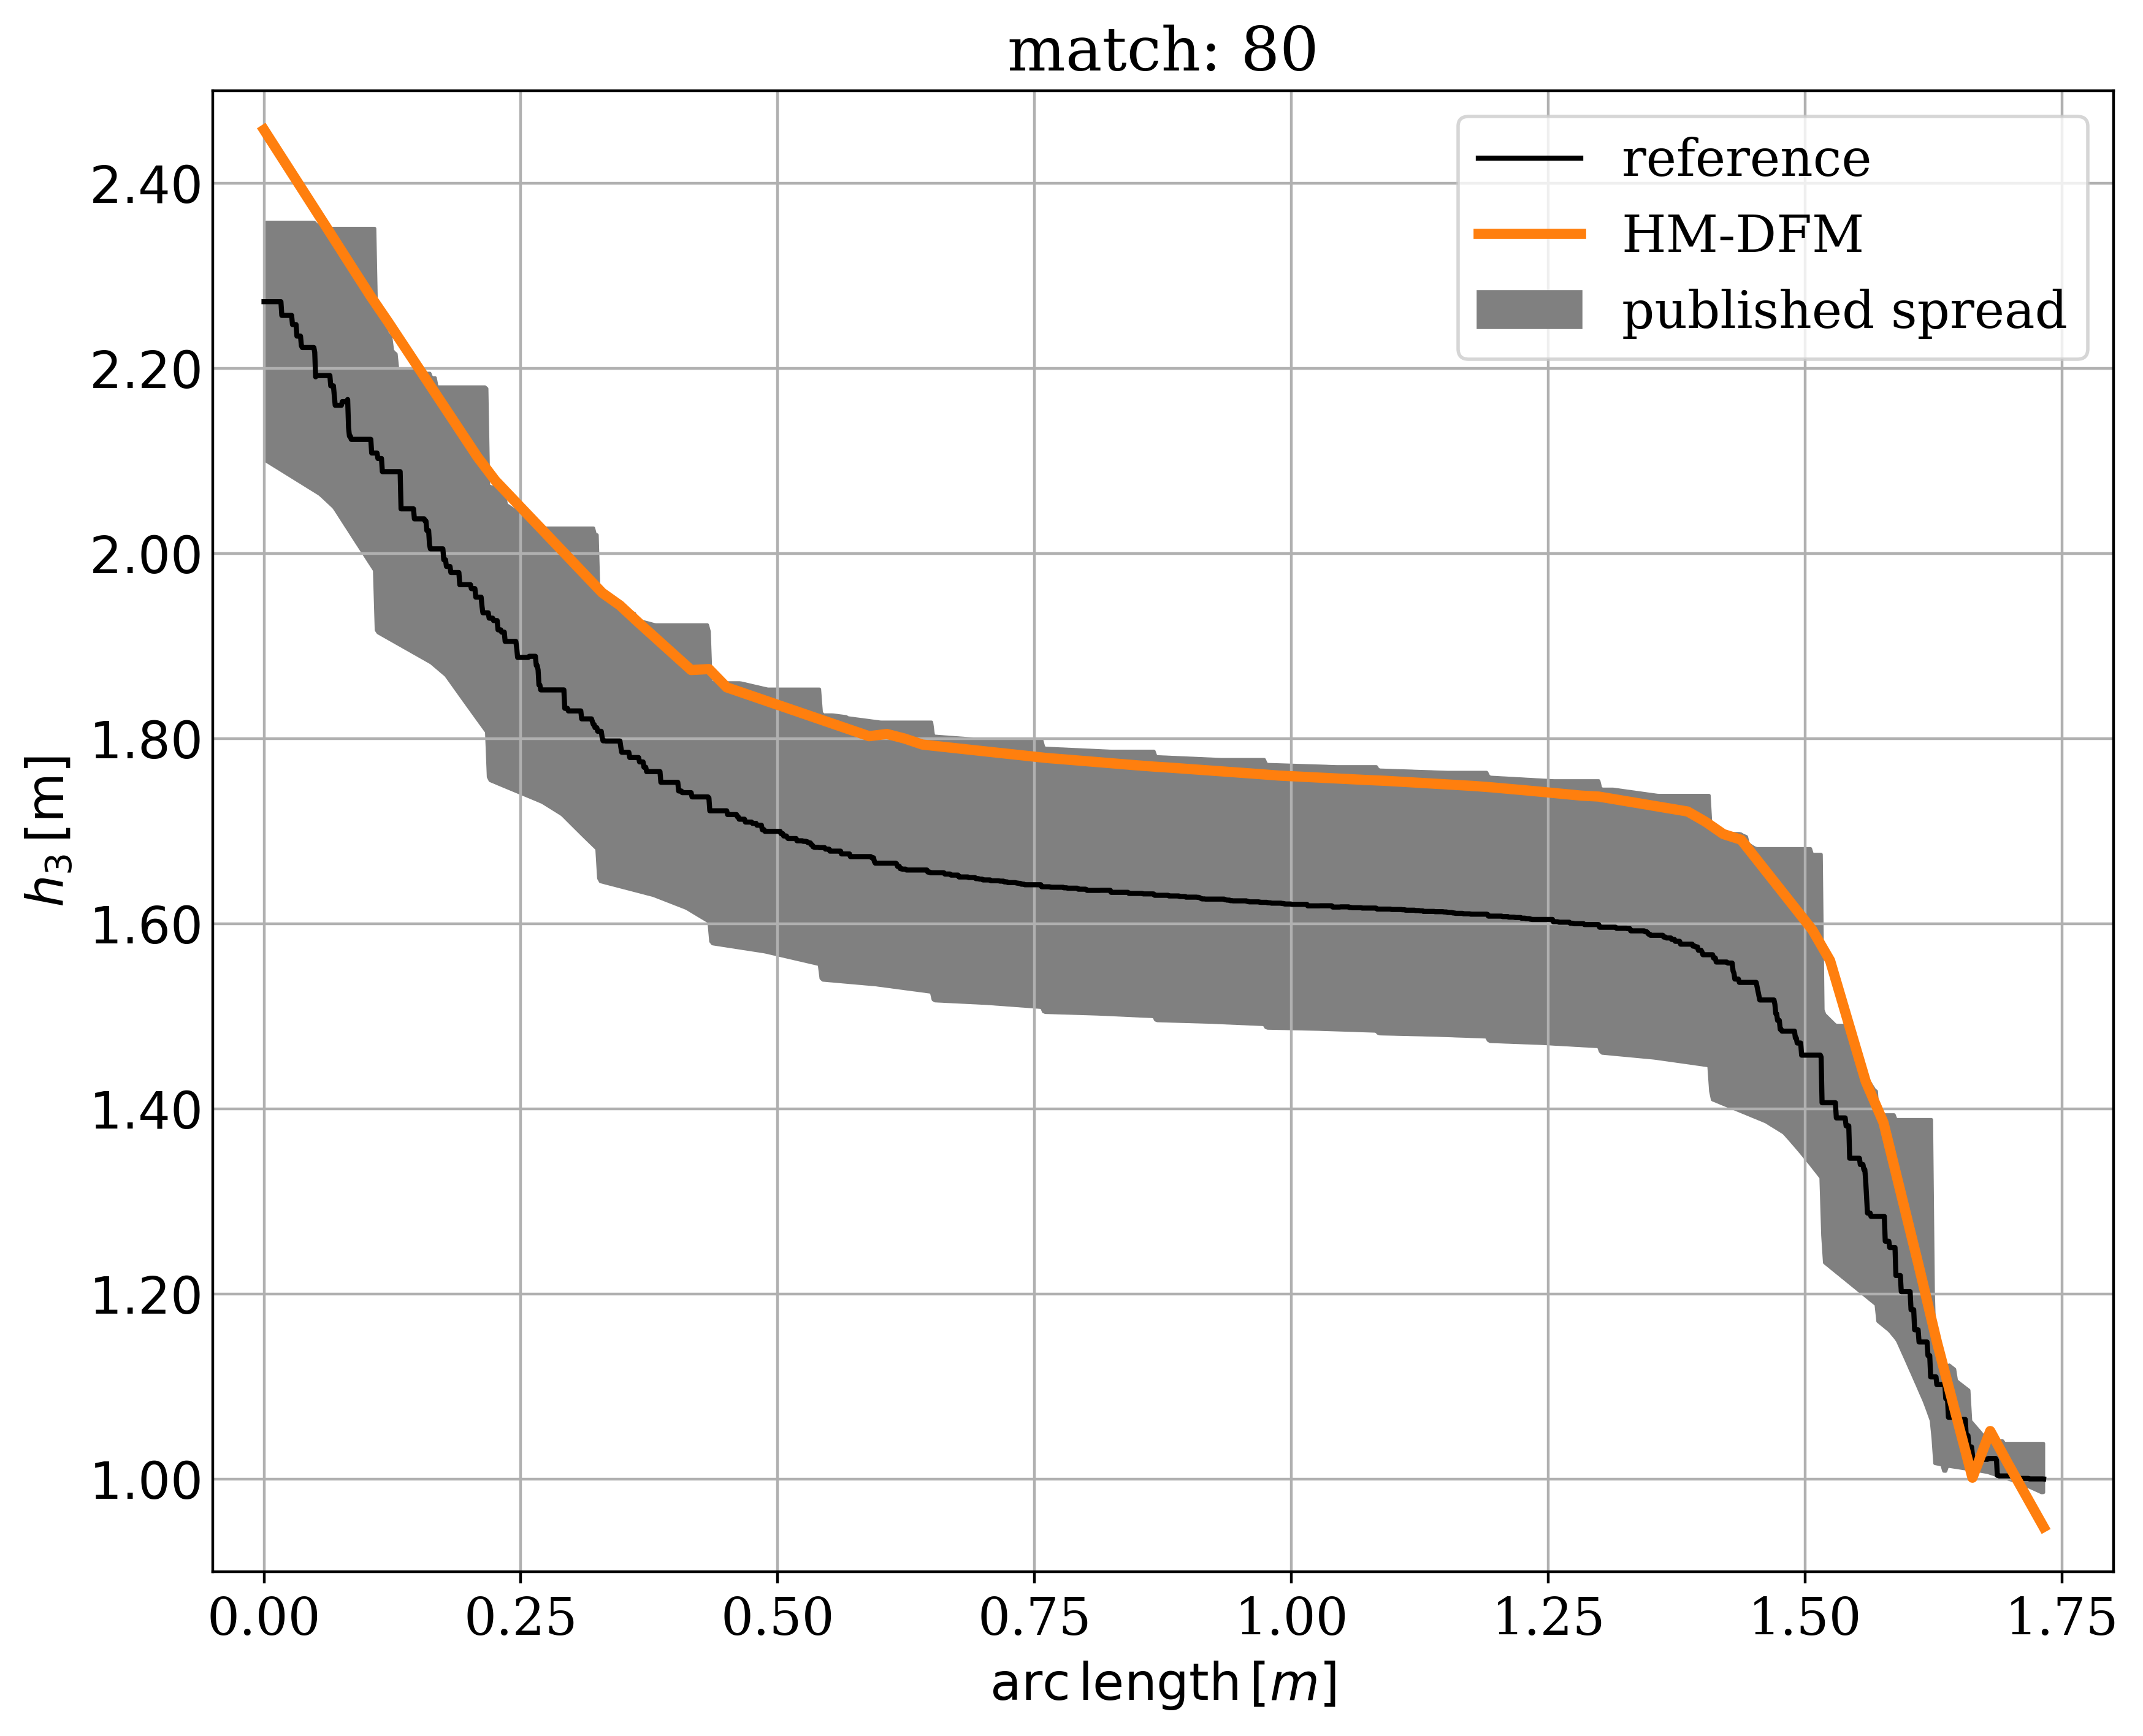

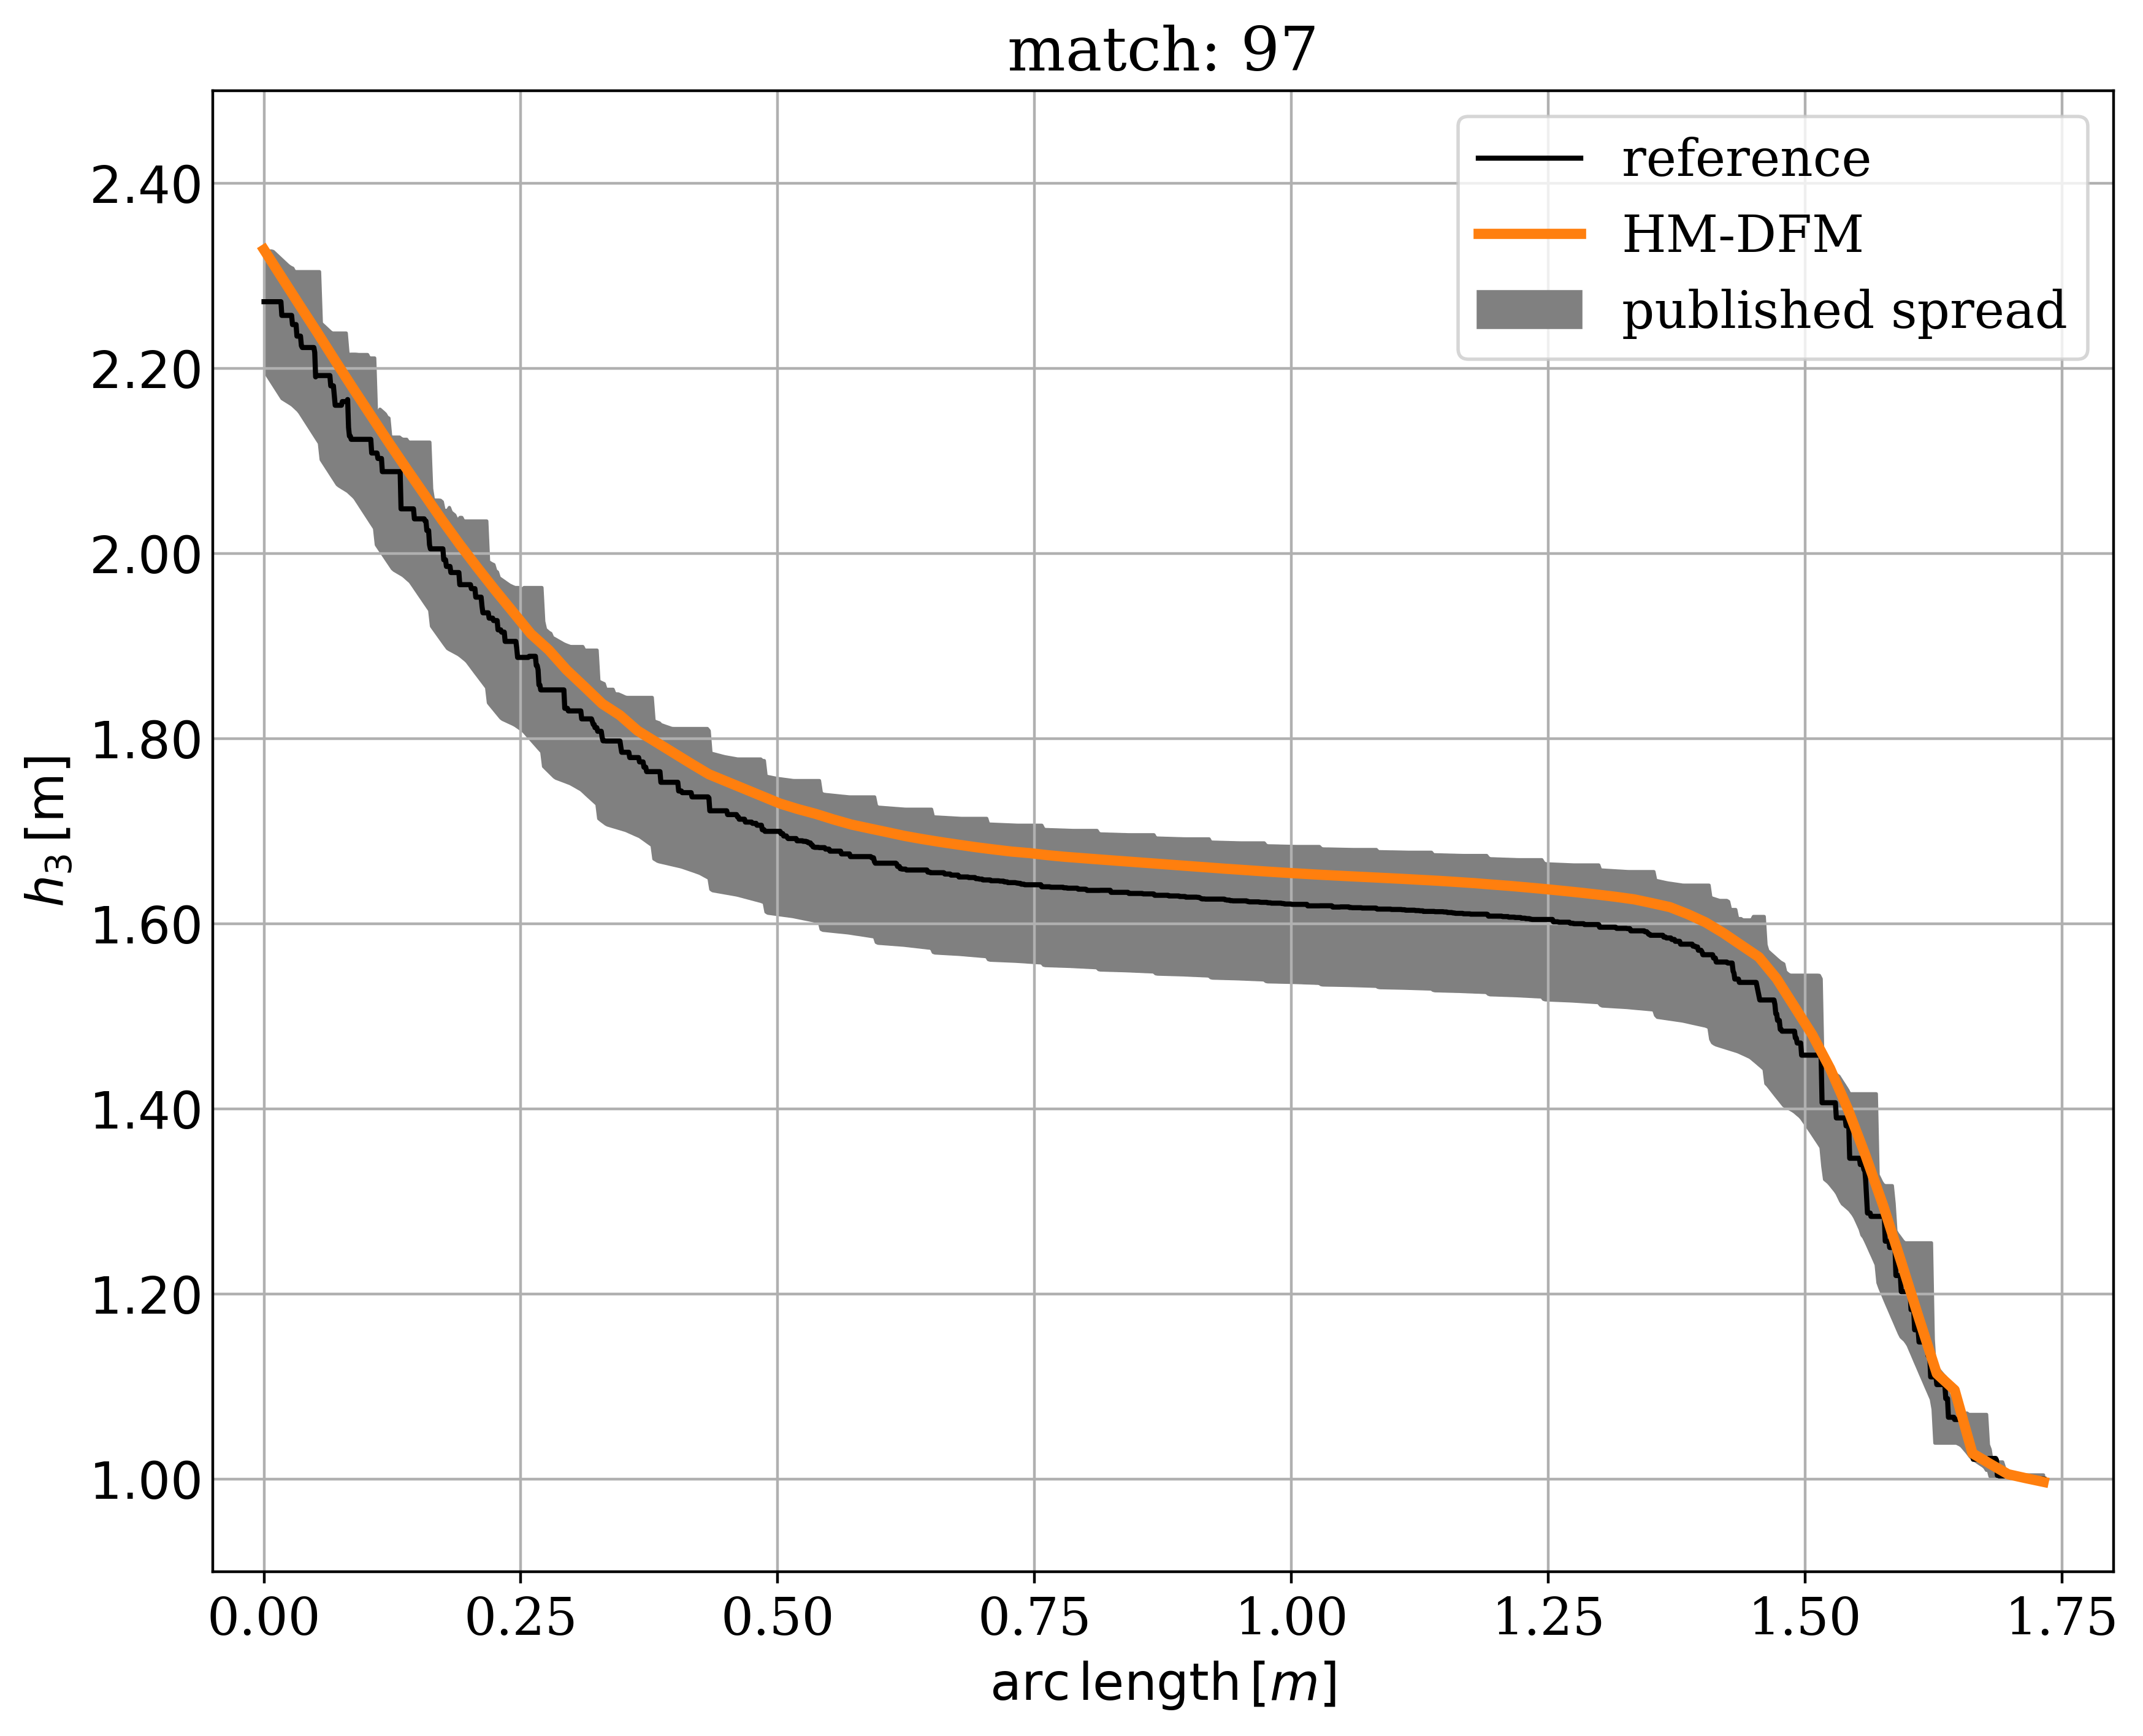

In [3]:
epsK1 = 1
for i in range(2):
    if i ==0:
        mesh, K0 = GenMesh(h0 = 0.2, h1 = 0.14, h2 = 0.08)
    else:
        mesh, K0 = GenMesh(h0 = 0.1, h1 = 0.064, h2 = 0.032)

    order = 0
    frac = "frac"
    V = Discontinuous(HDiv(mesh, order=order, RT=True))
    W = L2(mesh, order=order)
    M = FacetFESpace(mesh, order=order, dirichlet="inlet")
    Vf = Discontinuous(HDivSurface(mesh, order=order, RT=True), BND=True)
    for el in Vf.Elements(BND):
        if el.mat =="frac":
            for dof in el.dofs:
                Vf.FreeDofs()[dof] = True
                Vf.SetCouplingType(dof, COUPLING_TYPE.INTERFACE_DOF)
        else:
            for dof in el.dofs:
                Vf.FreeDofs()[dof] = False
                Vf.SetCouplingType(dof, COUPLING_TYPE.UNUSED_DOF)
    Vf = Compress(Vf)

    # Mf = Compress(FacetSurface(mesh, order=order, definedon=mesh.Boundaries(frac)))
    Mf = Compress(HCurl(mesh, order=order, definedon=mesh.Boundaries(frac))) # hacker?!

    fes = V*W*M*Vf*Mf

    h = specialcf.mesh_size
    n = specialcf.normal(3)
    t = specialcf.tangential(3)
    con = Cross(n,t) # co-normal
    t0 = specialcf.tangential(3,True)

    (u, p, phat, uf, pbar0), (v, q, qhat, vf, qbar0) = fes.TnT()
    pbar = pbar0.Trace()*t0
    qbar = qbar0.Trace()*t0

    condense=True
    a = BilinearForm(fes, condense=condense)

    # subdomain 1
    a += (1/K0*u*v-p*div(v)-q*div(u))*dx
    a += (1/epsK1*uf.Trace()*vf.Trace()-phat.Trace()*div(vf).Trace()-qhat.Trace()*div(uf).Trace()
         )*ds("frac")
    a += (v*n*phat+u*n*qhat)*dx(element_boundary=True)
    a += (vf.Trace()*con*pbar+uf.Trace()*con*qbar)*ds(element_boundary=True, definedon=mesh.Boundaries("frac"))

    f = LinearForm(fes)
    f += -qhat.Trace()*ds("outlet")
    gfu = GridFunction(fes)

    a.Assemble()
    f.Assemble()

    gfu.components[2].Set(1, definedon=mesh.Boundaries("inlet"))

    f.vec.data -= a.mat*gfu.vec
    if condense==True:
        f.vec.data += a.harmonic_extension_trans * f.vec
    gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense))*f.vec
    if condense==True:
        gfu.vec.data += a.harmonic_extension * gfu.vec 
        gfu.vec.data += a.inner_solve * f.vec

    # Local postprocessing
    V2 = L2(mesh, order=order+1, all_dofs_together=False)
    ph = GridFunction(V2)

    a2 = BilinearForm(V2)
    f2 = LinearForm(V2)

    p2, q2 = V2.TnT()
    a2 += grad(p2)*grad(q2)*dx
    a2.Assemble()
    f2 += -1/K0*gfu.components[0]*grad(q2)*dx
    f2.Assemble()

    V2.FreeDofs()[:mesh.ne]=False
    ph.vec[:mesh.ne].data=gfu.components[1].vec[:mesh.ne]
    ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec

    gfInterp = GridFunction(H1(mesh, order=order+1))
    gfInterp.Set(ph)
    Draw(gfInterp, mesh, "soln")

    ng = sum(fes.FreeDofs(True))
    nt = sum(fes.FreeDofs())
    print("NE: ", mesh.ne, "NDOF-g: ", ng, "NDOF-M:", sum(M.FreeDofs(True)), 
          "NDOF-Vf: ", sum(Vf.FreeDofs(True)), "NDOF-Mf: ", sum(Mf.FreeDofs(True)), "NDOF-l:", nt-ng)
    # data visualization over line
    xx = np.linspace(0, 1, 101)
    h = np.array([ph(mesh(x, x, x)) for x in xx])
    xx = xx*sqrt(3)

    plt.figure(figsize=(10,8), dpi=400)
    case = 2.1
    plot_id = "a"
    ref_index = i+1
    subdomain_id = 0
    compare_my_method.evaluate(xx, h, case, plot_id, ref_index, subdomain_id, name="HM-DFM")
    plt.axis([-0.05,1.80, 0.9,2.5])
    plt.savefig("data/regularC"+str(i+1)+".pdf", dpi=400)

# 3: Mixed: blocking (passed!)

matrix elements:  4375 ; fracture elements:  944


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  4375 NDOF-g:  8334
matrix elements:  36336 ; fracture elements:  4524


WebGuiWidget(value={'ngsolve_version': '6.2.2103-72-g646b7caba', 'mesh_dim': 3, 'order2d': 2, 'order3d': 2, 'd…

NE:  36336 NDOF-g:  70881


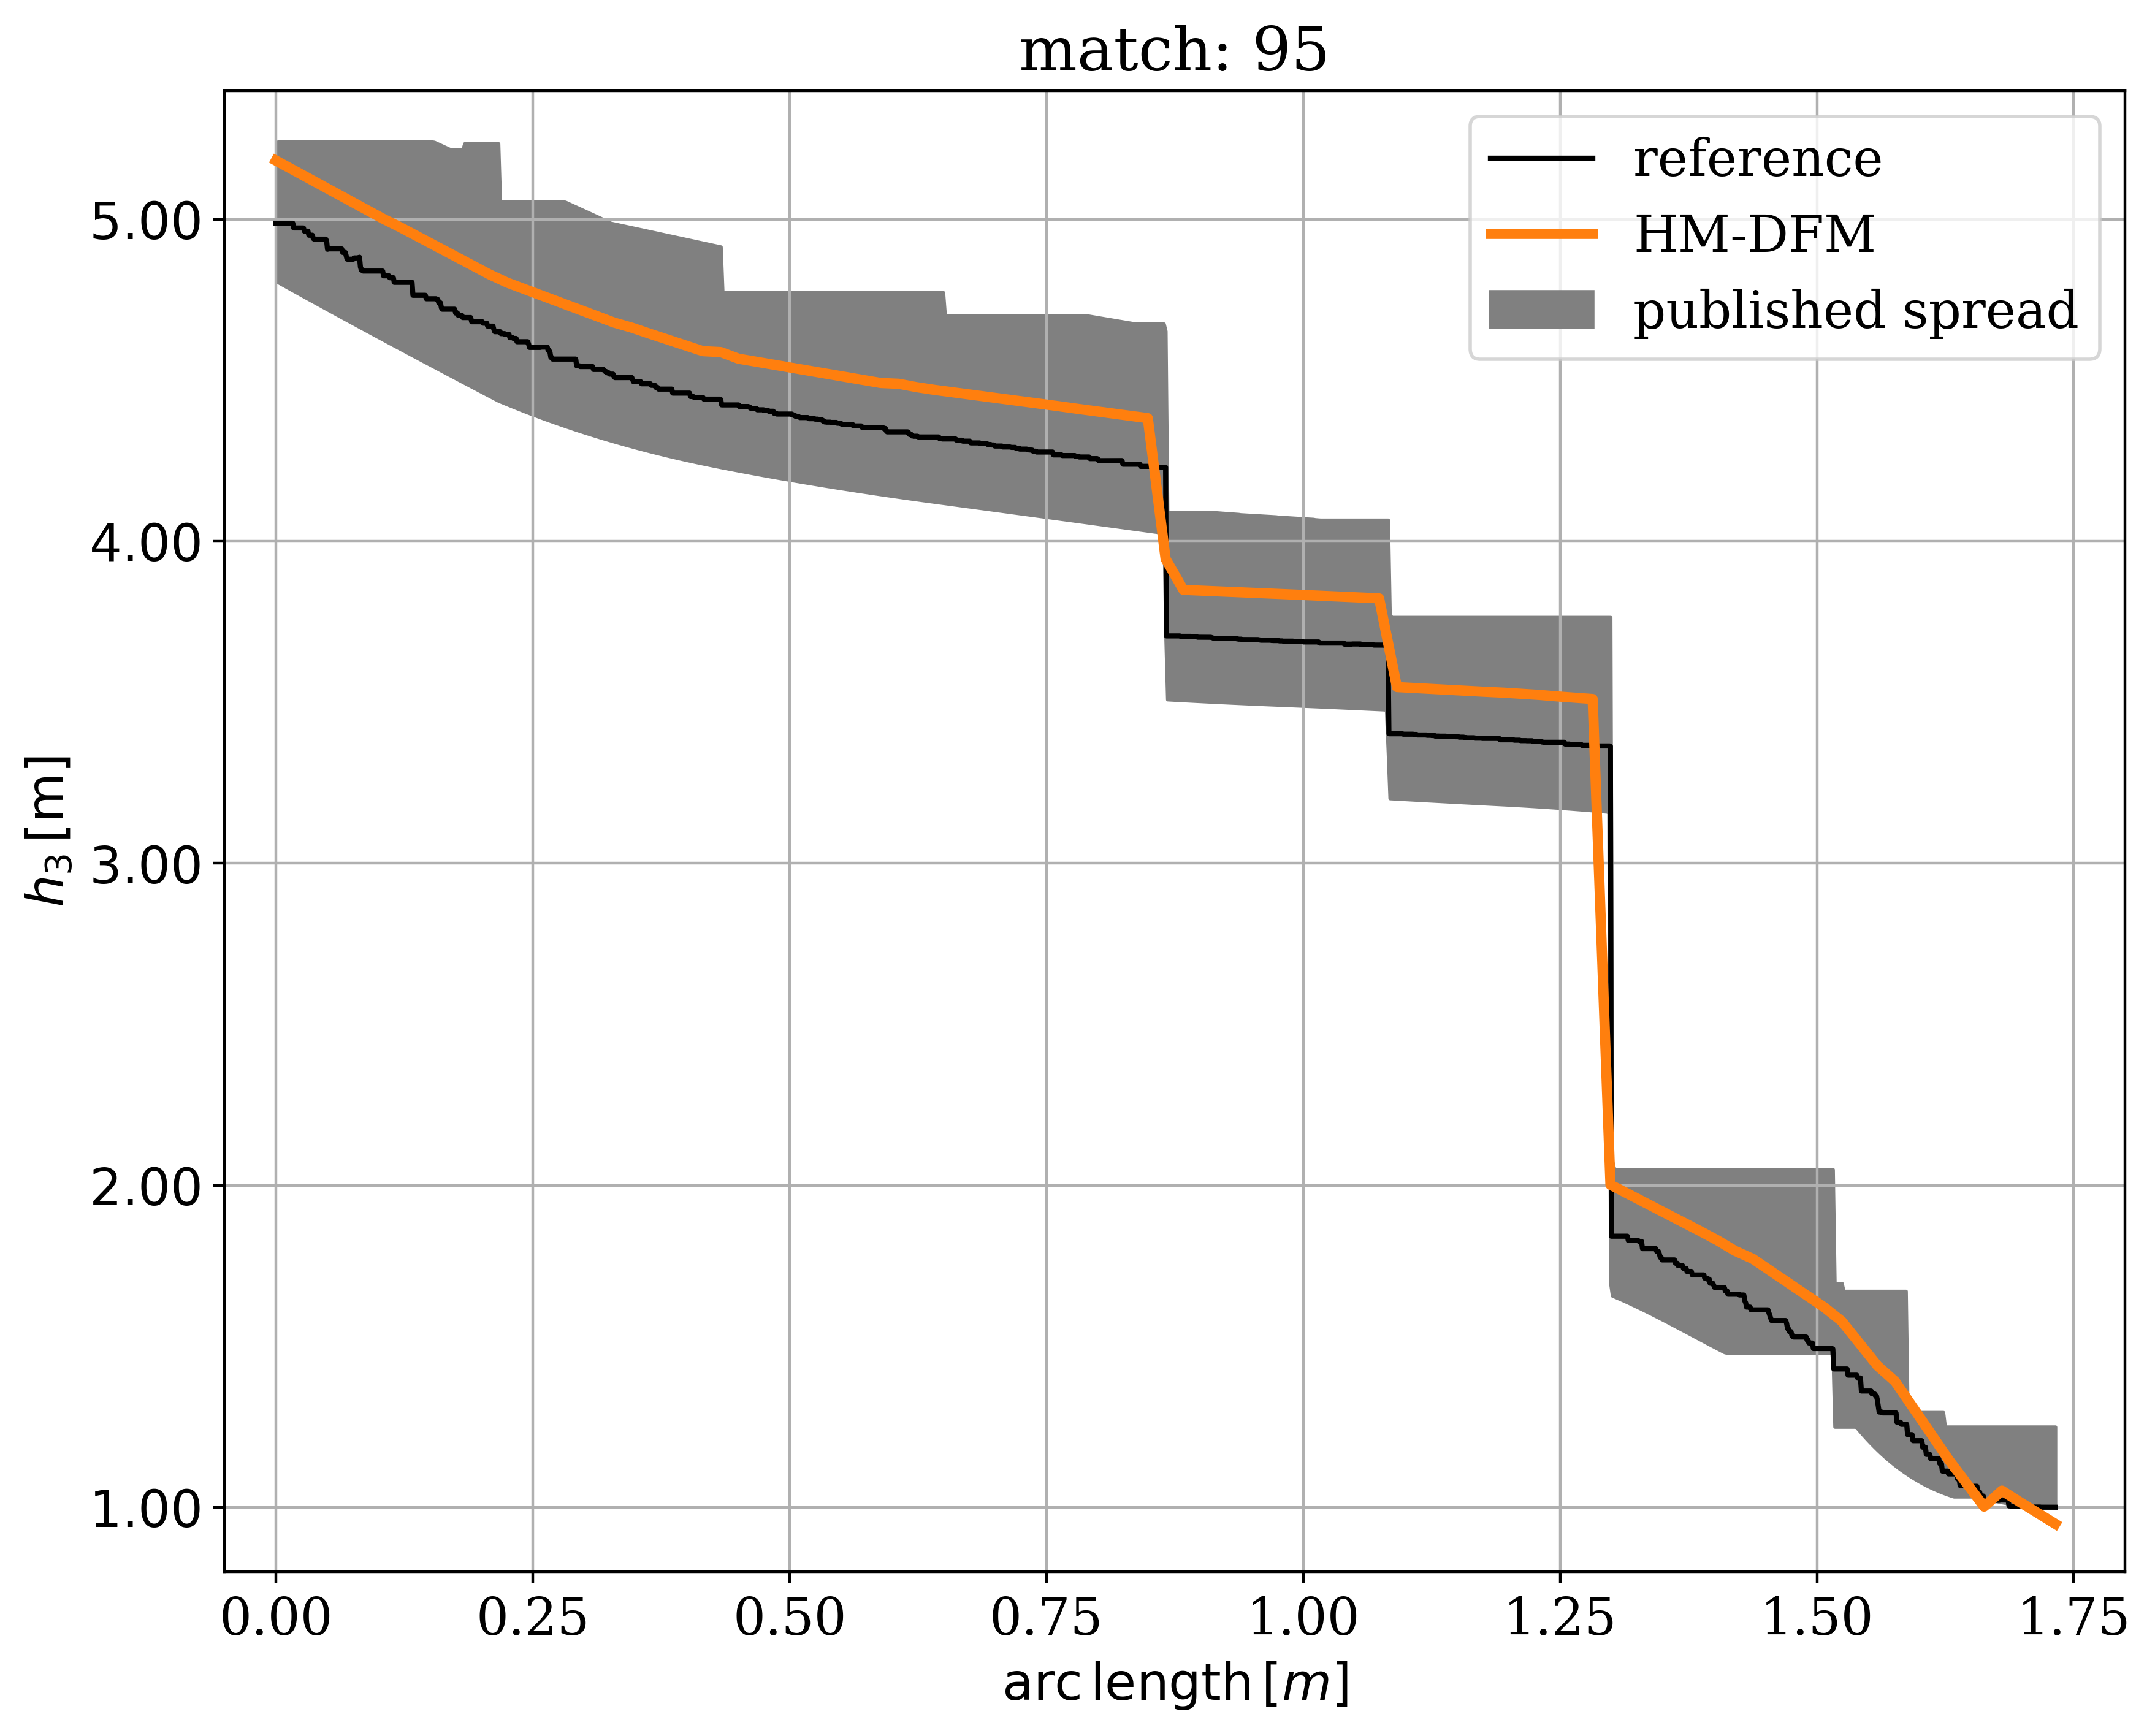

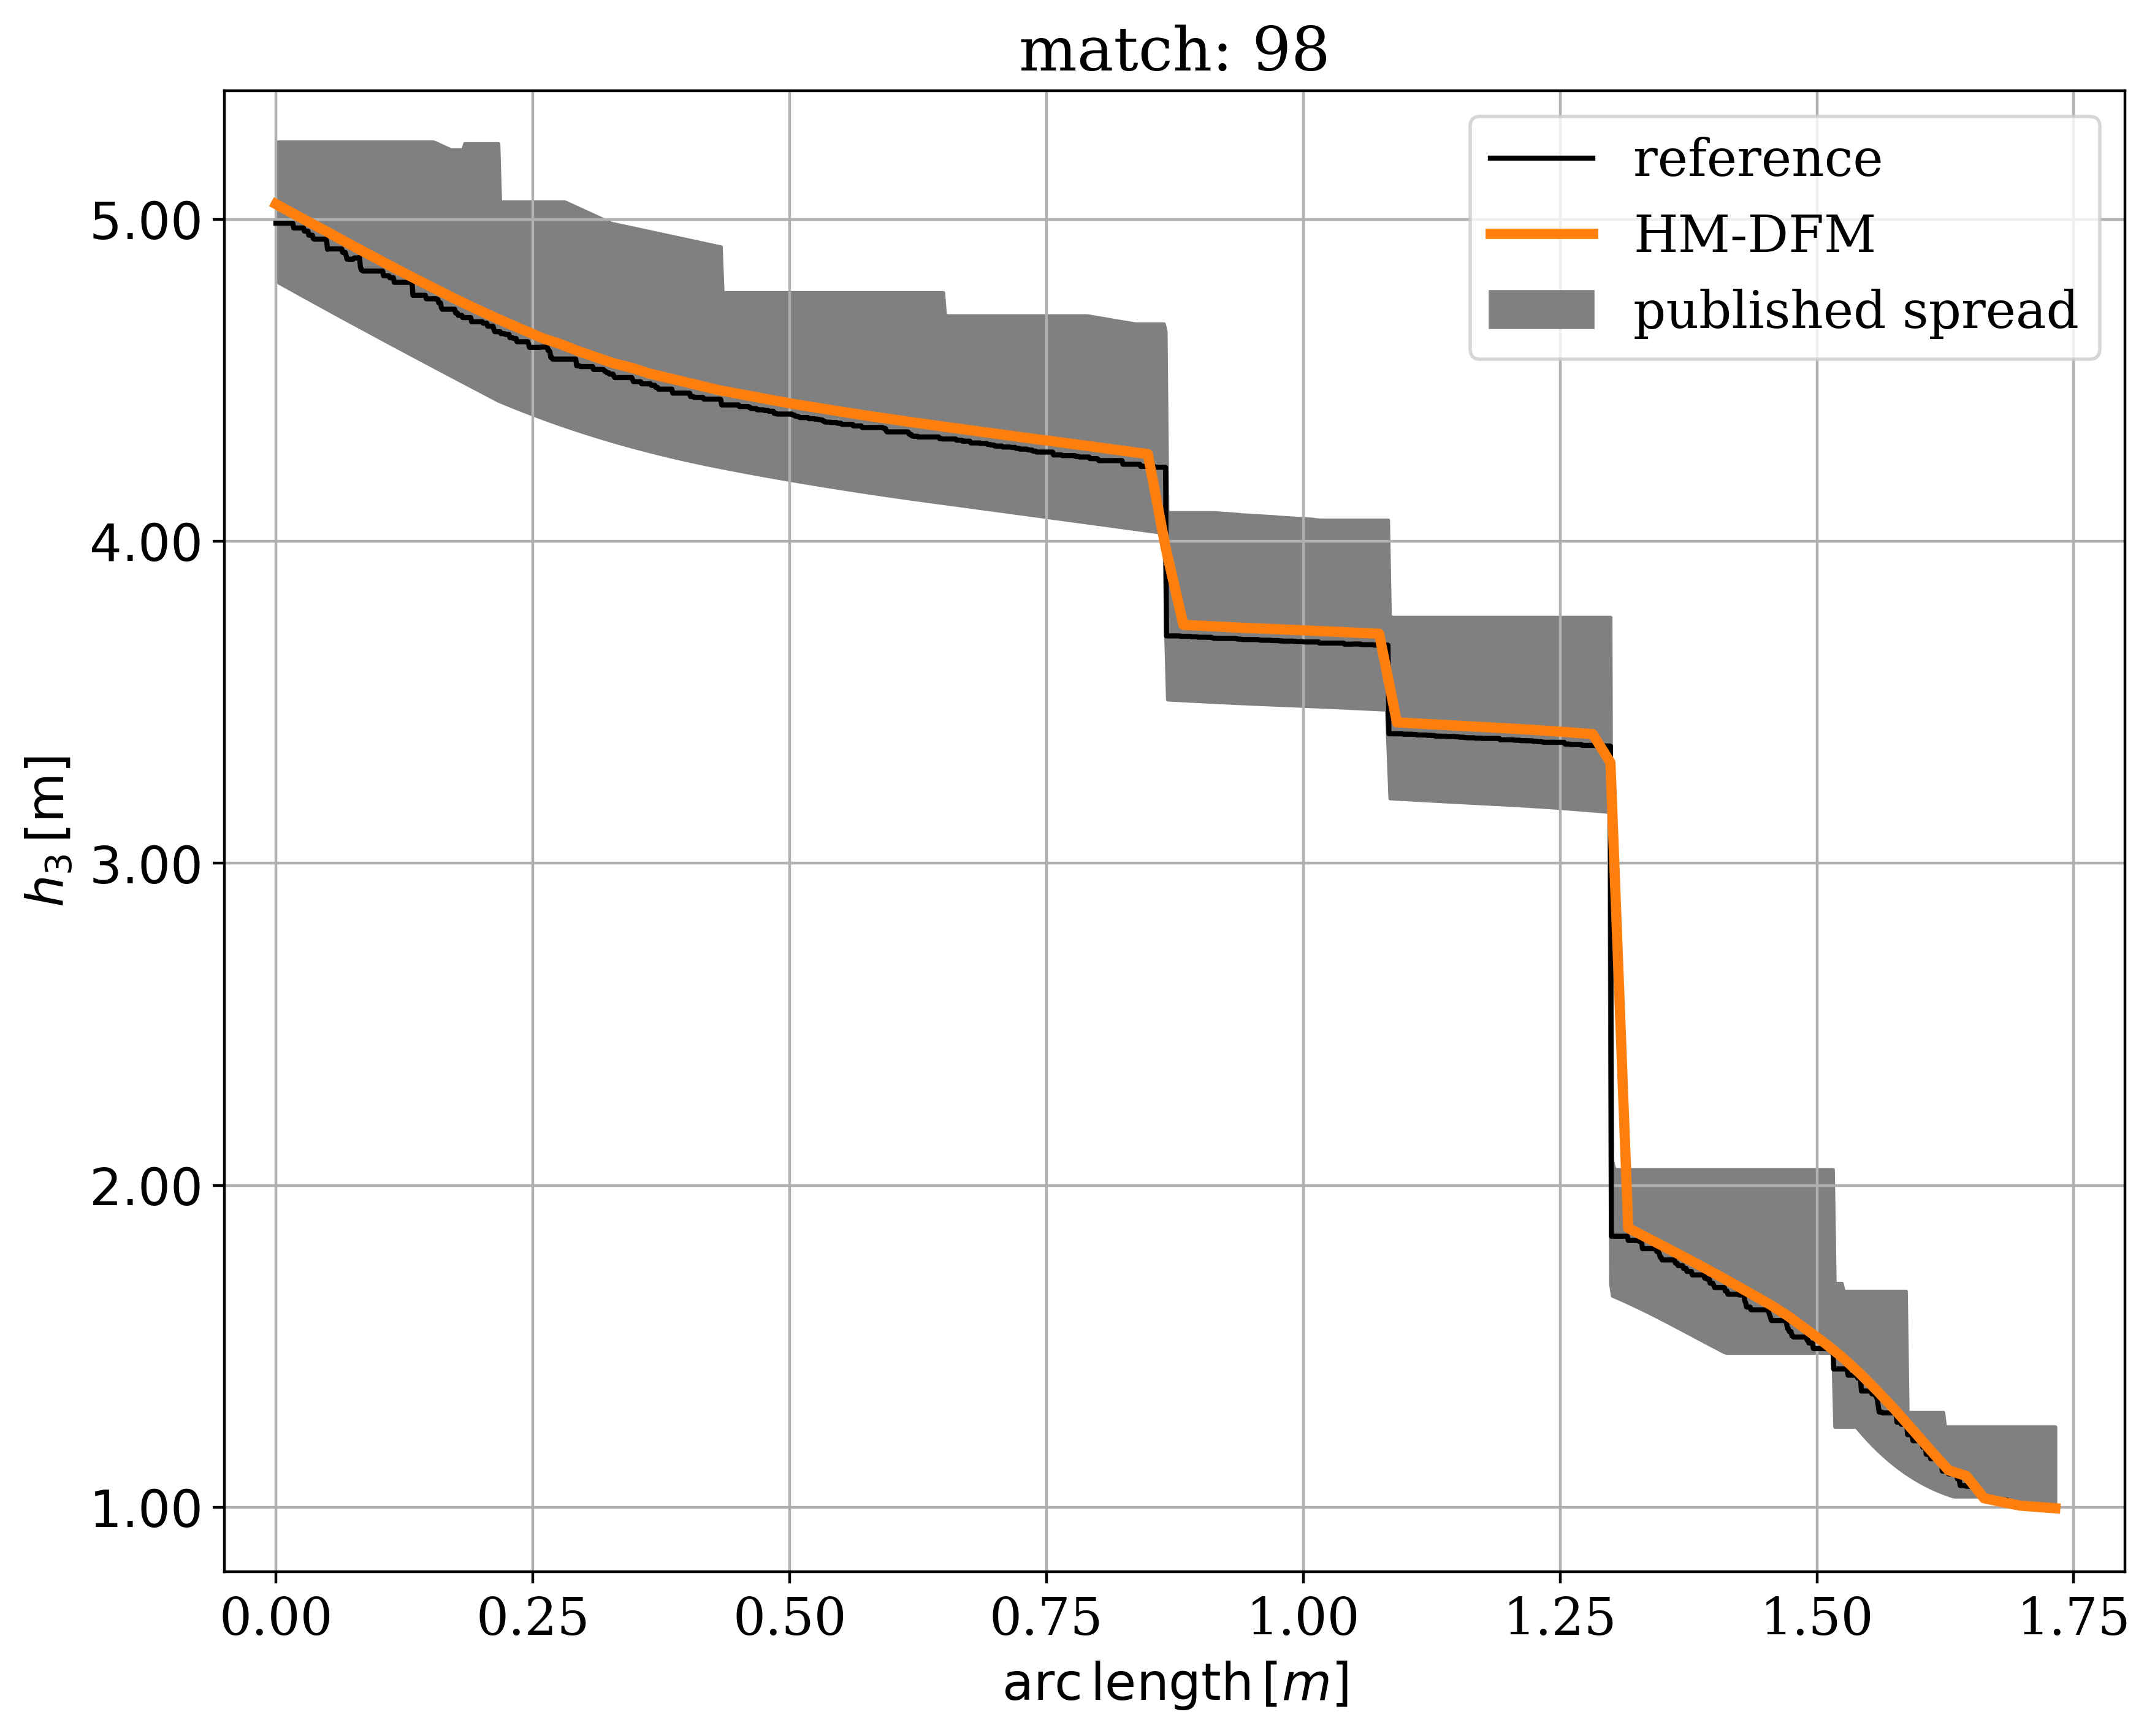

In [4]:
eps0, K2 = 1e-4, 1e-4
for i in range(2):
    if i ==0:
        mesh, K0 = GenMesh(h0 = 0.2, h1 = 0.14, h2 = 0.08)
    else:
        mesh, K0 = GenMesh(h0 = 0.1, h1 = 0.064, h2 = 0.032)
    order = 0
    frac = "frac"
    V = HDiv(mesh, order=order, dirichlet="noflow|outlet")
    W = L2(mesh, order=order)

    fes = V*W
    (u, p), (v, q) = fes.TnT()

    condense=False
    a = BilinearForm(fes, condense=condense)
    h = specialcf.mesh_size
    n = specialcf.normal(3)

    a += (1/K0*u*v-p*div(v)-q*div(u))*dx
    a += (eps0/K2*u.Trace()*v.Trace())*ds("frac")

    f = LinearForm(fes)
    f += -v.Trace()*n*ds("inlet")
    gfu = GridFunction(fes)

    a.Assemble()
    f.Assemble()

    gfu.components[0].Set(-n, definedon=mesh.Boundaries("outlet"))

    f.vec.data -= a.mat*gfu.vec
    if condense==True:
        f.vec.data += a.harmonic_extension_trans * f.vec
    gfu.vec.data += a.mat.Inverse(fes.FreeDofs(condense),inverse="umfpack")*f.vec
    if condense==True:
        gfu.vec.data += a.harmonic_extension * gfu.vec 
        gfu.vec.data += a.inner_solve * f.vec

    # Local postprocessing
    V2 = L2(mesh, order=order+1, all_dofs_together=False)
    ph = GridFunction(V2)

    a2 = BilinearForm(V2)
    f2 = LinearForm(V2)

    p2, q2 = V2.TnT()
    a2 += grad(p2)*grad(q2)*dx
    a2.Assemble()
    f2 += -1/K0*gfu.components[0]*grad(q2)*dx
    f2.Assemble()

    V2.FreeDofs()[:mesh.ne]=False
    ph.vec[:mesh.ne].data=gfu.components[1].vec[:mesh.ne]
    ph.vec.data += a2.mat.Inverse(V2.FreeDofs())*f2.vec

    gfInterp = GridFunction(H1(mesh, order=order+1))
    gfInterp.Set(ph)
    Draw(gfInterp, mesh, "soln")

    nt = sum(fes.FreeDofs(True))
    print("NE: ", mesh.ne, "NDOF-g: ", nt)
    # data visualization over line
    plt.figure(figsize=(10,8), dpi=400)
    xx = np.linspace(0, 1, 101)
    h = np.array([ph(mesh(x, x, x)) for x in xx])
    xx = xx*sqrt(3)

    case = 2.2
    plot_id = "a"
    ref_index = 0
    subdomain_id = 0
    compare_my_method.evaluate(xx, h, case, plot_id, ref_index, subdomain_id, name="HM-DFM")
    plt.axis([-0.05,1.80, 0.8,5.4])
    plt.savefig("data/regularB"+str(i+1)+".pdf", dpi=400)    